In [1]:
import os
import logging
import random
import gc
import time
import cv2
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy import signal
import timm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

In [2]:
class CFG:
    seed = 42  # Random seed for reproducibility
    debug = False  # Debug mode for faster iteration
    apex = False  # Use NVIDIA Apex for mixed precision training
    print_freq = 100  # Logging frequency (batches)
    num_workers = 2  # Number of dataloader subprocesses
    # File and directory paths
    OUTPUT_DIR = '/kaggle/working/'  # Directory to save outputs and models
    train_datadir = '/kaggle/input/birdclef-2025/train_audio'  # Path to training audio
    train_csv = '/kaggle/input/birdclef-2025/train.csv'  # Training metadata CSV
    train_soundscapes = '/kaggle/input/birdclef-2025/train_soundscapes'
    test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'  # Test soundscape audio
    submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'  # Sample submission format
    taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'  # Bird species taxonomy information   
    spectrogram_npy = '/kaggle/working/birdclef2025_melspec_5sec_256_256.npy'  # Cached mel spectrograms (optional)

    # Model configuration
    model_name = 'efficientnet_b0'  # Backbone model architecture
    model_path = '/kaggle/working/'  # Path to save/load model checkpoints
    pretrained = True  # Use pretrained weights
    in_channels = 1  # Number of input channels (e.g., 1 for mel-spectrograms)

    # Audio preprocessing
    LOAD_DATA = True  # Whether to load and preprocess audio data
    FS = 32000  # Sampling rate in Hz
    TARGET_DURATION = 5.0  # Target duration of each audio clip (in seconds)
    TARGET_SHAPE = (256, 256)  # Target shape for input spectrograms (H, W)

    # Mel spectrogram parameters
    N_FFT = 1024  # FFT window size
    HOP_LENGTH = 512  # Hop length for STFT
    N_MELS = 128  # Number of mel bands
    FMIN = 50  # Minimum frequency for mel filter bank
    FMAX = 14000  # Maximum frequency for mel filter bank
    WINDOW_SIZE = 5  # Median filter window size for noise reduction
    N_MAX = 50 if debug else None  # Optional limit on number of audio samples (for debug mode)

    # Preprocessing flags
    apply_noise_reduction = True  # Apply median filter-based noise reduction
    apply_normalization = True  # Normalize waveform amplitude
    noise_reduction_strength = 0.1  # Blending factor for noise reduction
    apply_spec_contrast = True  # Apply contrast enhancement to mel-spectrogram
    contrast_factor = 0.15  # Contrast enhancement factor

    # Training configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available
    epochs = 10  # Total number of training epochs
    batch_size = 32  # Batch size for training
    criterion = 'BCEWithLogitsLoss'  # Loss function (binary classification)

    # Cross-validation settings
    n_fold = 5  # Total number of folds
    selected_folds = [0, 1, 2, 3, 4]  # Folds to train on

    # Optimizer and scheduler
    optimizer = 'AdamW'  # Optimizer choice
    lr = 5e-4  # Learning rate
    weight_decay = 1e-5  # Weight decay for regularization

    scheduler = 'CosineAnnealingLR'  # Learning rate scheduler
    min_lr = 1e-6  # Minimum learning rate
    T_max = epochs  # Max number of iterations for scheduler

    # Data augmentation
    aug_prob = 0.5  # Probability of applying augmentations
    mixup_alpha = 0.5  # Alpha value for mixup augmentation

    def update_debug_settings(self):
        """
        Update training settings for debug mode to speed up experiments.
        """
        if self.debug:
            self.epochs = 2  # Fewer epochs for faster debugging
            self.selected_folds = [0]  # Use only one fold during debugging


In [3]:
# Audio processing functions
def reduce_noise(audio_data):
    """
    Apply noise reduction to audio data.

    :param audio_data: Raw audio waveform
    :return: Denoised audio waveform
    """
    if not CFG.apply_noise_reduction:
        return audio_data

    # Apply median filter for basic noise suppression
    window_size = 5
    audio_denoised = signal.medfilt(audio_data, window_size)

    # Blend original and denoised signal based on reduction strength
    return (1 - CFG.noise_reduction_strength) * audio_data + CFG.noise_reduction_strength * audio_denoised


def normalize_audio(audio_data):
    """
    Normalize the audio waveform.

    :param audio_data: Raw audio waveform
    :return: Normalized audio waveform
    """
    if not CFG.apply_normalization:
        return audio_data

    # Remove DC offset
    audio_data = audio_data - np.mean(audio_data)

    # Normalize to max absolute amplitude of 1
    max_amplitude = np.max(np.abs(audio_data))
    if max_amplitude > 0:
        audio_data = audio_data / max_amplitude

    return audio_data


def enhance_spectrogram_contrast(spec, factor=0.15):
    """
    Enhance the contrast of the spectrogram to highlight features.

    :param spec: Input spectrogram (normalized)
    :param factor: Contrast enhancement factor (typically in range 0.05~0.2)
    :return: Contrast-enhanced spectrogram
    """
    mean = np.mean(spec)
    enhanced = mean + (spec - mean) * (1 + factor)
    return np.clip(enhanced, 0, 1)  # Ensure values remain in [0, 1]


#############################################################################
def audio2melspec(audio_data, cfg=CFG):
    """
    Convert raw audio data into a normalized and contrast-enhanced Mel spectrogram.

    :param audio_data: Raw 1D audio waveform
    :param cfg: Configuration object with processing parameters
    :return: Processed Mel spectrogram (float32, shape=cfg.TARGET_SHAPE)
    """

    # Handle potential NaN values (replacing with mean value)
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    # Pad the signal if it's shorter than the required window length
    required_length = CFG.FS * CFG.WINDOW_SIZE
    if len(audio_data) < required_length:
        audio_data = np.pad(
            audio_data,
            (0, required_length - len(audio_data)),
            mode='constant'
        )

    # Apply noise reduction and normalization
    audio_data = reduce_noise(audio_data)
    audio_data = normalize_audio(audio_data)

    # Generate Mel spectrogram from the waveform
    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=cfg.FS,
        n_fft=cfg.N_FFT,
        hop_length=cfg.HOP_LENGTH,
        n_mels=cfg.N_MELS,
        fmin=cfg.FMIN,
        fmax=cfg.FMAX,
        power=2.0
    )

    # Convert to log-scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize to [0, 1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)

    # Apply contrast enhancement if enabled
    if CFG.apply_spec_contrast:
        mel_spec_norm = enhance_spectrogram_contrast(mel_spec_norm, CFG.contrast_factor)
    # # Resize spectrogram to target shape for model input
    # if mel_spec_norm.shape != cfg.TARGET_SHAPE:
    #     mel_spec_norm = cv2.resize(mel_spec_norm, cfg.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

    return mel_spec_norm.astype(np.float32)

In [4]:
def generate_spectrograms(working_df, cfg):
    """
    Generate and save mel spectrograms from a set of audio files.

    :param working_df: A pandas DataFrame containing audio metadata including file paths
    :param cfg: Configuration object containing parameters for audio processing
    :return: Dictionary mapping sample names to spectrogram arrays
    """
    print("Generating mel spectrograms from audio files...")

    all_bird_data = {}  # Dictionary to store sample_name -> spectrogram
    errors = []  # Keep track of failed files

    total_samples = len(working_df)
    start_time = time.time()

    for i, row in tqdm(working_df.iterrows(), total=total_samples):
        # If in debug mode, limit the number of processed samples
        if cfg.N_MAX is not None and i >= cfg.N_MAX:
            break

        try:
            # Load audio file and resample to target sample rate
            audio_data, _ = librosa.load(row.filepath, sr=cfg.FS)

            target_samples = int(cfg.TARGET_DURATION * cfg.FS)

            # If the audio is shorter than target duration, repeat it
            if len(audio_data) < target_samples:
                n_copy = math.ceil(target_samples / len(audio_data))
                if n_copy > 1:
                    audio_data = np.concatenate([audio_data] * n_copy)

            # Center-crop the audio to the target length
            start_idx = max(0, int(len(audio_data) / 2 - target_samples / 2))
            end_idx = min(len(audio_data), start_idx + target_samples)
            center_audio = audio_data[start_idx:end_idx]

            # Pad if still shorter than target length
            if len(center_audio) < target_samples:
                center_audio = np.pad(center_audio, 
                                      (0, target_samples - len(center_audio)), 
                                      mode='constant')

            # Generate mel spectrogram from audio segment
            mel_spec = audio2melspec(center_audio, cfg)

            # Ensure spectrogram has the correct shape
            if mel_spec.shape != cfg.TARGET_SHAPE:
                mel_spec = cv2.resize(mel_spec, cfg.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

            # Store processed spectrogram
            all_bird_data[row.samplename] = mel_spec.astype(np.float32)

        except Exception as e:
            # Handle and log any errors
            print(f"Error processing {row.filepath}: {e}")
            errors.append((row.filepath, str(e)))

    end_time = time.time()
    print(f"Processing completed in {end_time - start_time:.2f} seconds")
    print(f"Successfully processed {len(all_bird_data)} files out of {total_samples} total")
    print(f"Failed to process {len(errors)} files")

    # Save all spectrograms to a .npy file for quick loading later
    np.save(cfg.spectrogram_npy, all_bird_data)
    print(f"Spectrograms saved to: {os.path.abspath(cfg.spectrogram_npy)}")

    return all_bird_data

In [5]:
def plot_melspec_examples(working_df, cfg, all_bird_data):
    """
    Plot and save example mel spectrograms from the processed dataset.

    :param working_df: DataFrame containing metadata for each audio sample
    :param cfg: Configuration object
    :param all_bird_data: Dictionary of {samplename: mel spectrogram array}
    """
    samples = []  # List to store selected sample info for plotting
    displayed_classes = set()  # Track which bird classes have been shown to avoid repetition

    # Limit the number of displayed examples (up to 4)
    max_samples = min(4, len(all_bird_data))

    # Select samples to plot, ensuring diverse classes
    for i, row in working_df.iterrows():
        # Stop if we've reached the max limit (controlled by debug or full mode)
        if i >= (cfg.N_MAX or len(working_df)):
            break

        # Only proceed if spectrogram data exists for the sample
        if row['samplename'] in all_bird_data:
            # In both debug and full mode, we try to show unique classes
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])

            if len(samples) >= max_samples:
                break

    # Proceed only if there are valid samples to display
    if samples:
        plt.figure(figsize=(16, 12))  # Set the figure size

        for i, (samplename, class_name, species) in enumerate(samples):
            plt.subplot(2, 2, i + 1)  # 2x2 grid layout
            plt.imshow(
                all_bird_data[samplename],
                aspect='auto',
                origin='lower',
                cmap='viridis'
            )
            plt.title(f"{class_name}: {species}")  # Title with class and primary label
            plt.colorbar(format='%+2.0f dB')  # Show color scale for intensity

        plt.tight_layout()  # Automatically adjust subplot spacing
        debug_note = "debug_" if cfg.debug else ""  # Add prefix to file if in debug mode
        plt.savefig(f'{debug_note}melspec_examples.png')  # Save to file
        plt.show()  # Display the plot inline


Starting audio processing...
FULL MODE - Processing all samples
Debug mode: OFF
Max samples to process: ALL
Loading taxonomy data...
Loading training metadata...
Found 206 unique species
Total samples to process: 28564 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64
Generating mel spectrograms from audio files...


  0%|          | 0/28564 [00:00<?, ?it/s]

Processing completed in 1721.37 seconds
Successfully processed 28564 files out of 28564 total
Failed to process 0 files
Spectrograms saved to: /kaggle/working/birdclef2025_melspec_5sec_256_256.npy


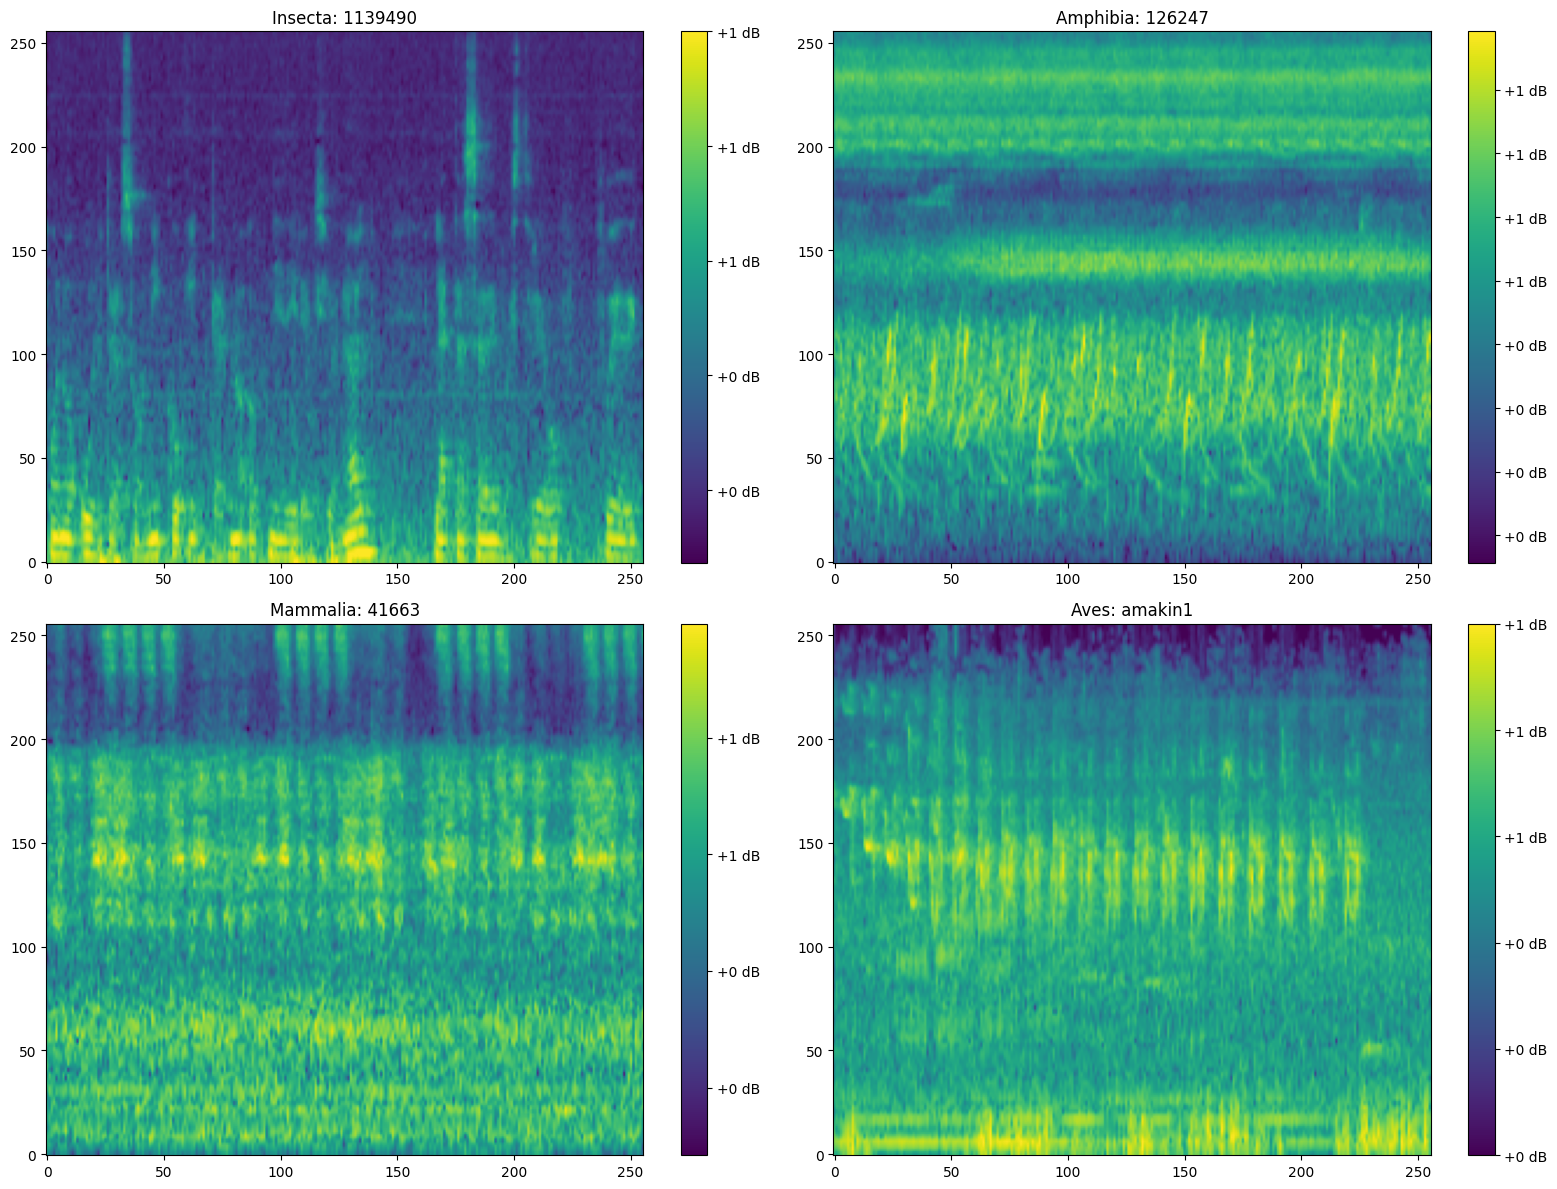

In [6]:
# Instantiate configuration
cfg = CFG()

# Logging basic configuration info
print("Starting audio processing...")
print(f"{'DEBUG MODE - Processing only 50 samples' if cfg.debug else 'FULL MODE - Processing all samples'}")

# Start timer
start_time = time.time()

# Print debug setting
print(f"Debug mode: {'ON' if cfg.debug else 'OFF'}")
print(f"Max samples to process: {cfg.N_MAX if cfg.N_MAX is not None else 'ALL'}")

# Load taxonomy mapping: primary label to human-readable class name
print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

# Load training metadata: includes labels and filenames
print("Loading training metadata...")
train_df = pd.read_csv(cfg.train_csv)

# Create mappings from label to numeric ID and vice versa
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')

# Create a working dataframe with essential columns and paths
working_df = train_df[['primary_label', 'rating', 'filename']].copy()

# Map label to numeric target ID
working_df['target'] = working_df.primary_label.map(label2id)

# Construct full filepath to audio file
working_df['filepath'] = cfg.train_datadir + '/' + working_df.filename

# Generate a unique sample name using folder name and file basename
working_df['samplename'] = working_df.filename.map(
    lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0]
)

# Map primary label to its readable class name
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))

# Limit the number of samples to process if in debug mode
total_samples = min(len(working_df), cfg.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')

# Print number of samples per class
print(f'Samples by class:')
print(working_df['class'].value_counts())

# Generate mel spectrograms from audio files
all_bird_data = generate_spectrograms(working_df, cfg)

# Visualize and save sample spectrograms
plot_melspec_examples(working_df, cfg, all_bird_data)